A recent talk made me think about measuring the distance between a concept and a text. I know that, for example, Dustin Stolz and Marshall A. Taylor developed “[Concept Mover’s Distance]( https://www.textmapping.com)” and that folks like [Laura K. Nelson]( https://www.lauraknelson.com) have done nifty things, but I haven’t really thought about the idea much in years. Most of the sociological work has used word embeddings, which are constructed using algorithms like Word2Vec, GloVe, or FastText, to analyze a set of texts and translate words into vectors based on the context in which words appear and their co-occurrence with other words. These vectors capture semantic and syntactic similarities among words. Sentences, paragraphs, or longer texts are represented as the average value of their word embeddings, and the method works quite well for measuring how similar two texts are based on the distance between their word embeddings. In contrast, *sentence embeddings* generated from models like BERT or other transformer-based architectures do not merely combine word vectors. Instead, these models are trained to understand the context and relationships between words in a sentence, producing embeddings that capture the nuanced meaning of the entire sentence. Fine-tuning these models on specific tasks, such as text similarity, further enhances their ability to represent sentences in a way that aligns with the task's requirements. The resulting *[sentence transformer]( https://www.sbert.net/#)* models seem to be what most people are using today, so I thought I would play around with them. That said, most of the interesting sociological work has been folks computing their own word vectors, but I'm just going to use a pretrained model. 

In [49]:
pip install -U --q sentence-transformers

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [50]:
from sentence_transformers import SentenceTransformer, util
import torch
import pandas as pd
import numpy as np
import warnings

# Show wider columns
pd.set_option('display.max_colwidth', 200)


# Filter out all warnings
warnings.filterwarnings("ignore")

There are [lots of different pretrained SentenceTransformer models](https://www.sbert.net/docs/pretrained_models.html) to try. Since I don't have a GPU, I'm using the smallest decent one.

In [51]:
model = SentenceTransformer('all-MiniLM-L6-v2')

Encoding a sentence returns an array, with each position measuring some latent aspect of the sentence. The `all-MiniLM-L6-v2` model has 384 dimensions, meaning it represents sentences in a 384-dimensional space where each dimension captures a different aspect of the sentence's semantic and syntactic properties.

In [52]:
model.encode('We study apples.')

array([ 7.25412294e-02,  2.94132698e-02, -1.04851276e-02,  7.10855499e-02,
       -1.60725769e-02, -1.44585697e-02,  2.01909002e-02, -1.64043065e-02,
        5.85170425e-02,  4.42925990e-02,  3.38043720e-02, -3.70339900e-02,
       -1.01375952e-02,  1.51030989e-02, -2.33681127e-02, -7.01107532e-02,
       -6.28457516e-02, -1.98269282e-02, -2.56151836e-02, -3.29240002e-02,
       -3.28812934e-02,  1.20462896e-02,  2.59449407e-02, -9.30627715e-03,
        3.87127437e-02,  5.07903211e-02,  1.87327876e-03, -3.24000195e-02,
       -3.31559330e-02, -2.26897225e-02, -3.54236215e-02,  5.46763092e-02,
        9.66718495e-02,  3.60654816e-02, -5.42746857e-02, -6.75004860e-03,
        1.40686721e-01, -5.24841994e-02,  2.66690422e-02, -1.14018116e-02,
       -5.27682193e-02,  7.28323534e-02,  2.73659322e-02,  1.07277647e-01,
        1.61659811e-02,  3.81597877e-02, -1.69903729e-02, -3.23689356e-02,
        2.42316276e-02,  6.92270622e-02, -7.24644810e-02,  5.75410959e-04,
       -2.30131280e-02, -

In [53]:
len(model.encode('We study apples.'))

384

A little function to compare the embeddings of a single concept with each word in a sentence, and then the entire sentence. I built this to confirm that sentence embeddings actually do what I think they are doing.

In [54]:
def concept_string_sim(concept, 
                       text
):
    concept_emedding = model.encode(concept)
    for word in text.split():
        word_embedding = model.encode(word)
        similarity = util.pytorch_cos_sim(concept_emedding, word_embedding)[0][0]
        print(f'Similarity between {word} and {concept} is {similarity:.2f}.')

    text_embedding = model.encode(text)
    similarity = util.pytorch_cos_sim(concept_emedding, text_embedding)[0][0]
    print(f'Similarity between {text} and {concept} is {similarity:.2f}.')


In [55]:
concept_string_sim('rock, music', 'Grateful Dead show')

Similarity between Grateful and rock, music is 0.18.
Similarity between Dead and rock, music is 0.37.
Similarity between show and rock, music is 0.28.
Similarity between Grateful Dead show and rock, music is 0.36.


In [56]:
concept_string_sim('thankful attitude', 'Grateful Dead show')

Similarity between Grateful and thankful attitude is 0.50.
Similarity between Dead and thankful attitude is 0.23.
Similarity between show and thankful attitude is 0.20.
Similarity between Grateful Dead show and thankful attitude is 0.20.


In the first example, the concept "rock, music" shows varying degrees of similarity with each word in the sentence "Grateful Dead show," with the highest similarity observed with the word "Dead" (0.37), suggesting that the model captures the association between the band "Grateful Dead" and rock music. The overall sentence similarity score (0.36) closely aligns with the highest word similarity score, indicating that sentence embeddings can indeed capture the essence of the concept in relation to the full sentence context.

In the second case, the concept "thankful attitude" has the highest similarity with the word "Grateful" (0.50), which is intuitive given the semantic closeness of "thankful" and "Grateful." However, the overall similarity between the entire sentence "Grateful Dead show" and the concept "thankful attitude" is lower (0.20), suggesting that while individual words like "Grateful" strongly resonate with the concept, the context provided by the entire sentence shifts the meaning away from the concept's core, demonstrating how sentence embeddings can differentiate between the significance of individual words and the collective meaning of a sentence.

No measuring some sentence similarities.

In [57]:
def string_string_sim(text1,
                      text2,
):
    text1_embedding = model.encode(text1)
    text2_embedding = model.encode(text2)

    similarity = util.pytorch_cos_sim(text1_embedding, text2_embedding)[0][0]
    print(f'Similarity is {similarity:.2f}.')

In [58]:
string_string_sim('We study revolutions.', 'This paper examines social movements.')

Similarity is 0.47.


In [59]:
string_string_sim('We study revolutions.', 'This paper examines health behaviors.')

Similarity is 0.18.


In [60]:
string_string_sim('We study revolutions.', 'This paper examines social movements in Algeria during the 1970s.')

Similarity is 0.36.


This also worked. Note, however, that the last example had a lower correlation with "We study revolutions." This is because the the additional information in the sentence, like the country and time, were uncorrelated with the shorter, first sentence. I suspect this means that, on average, longer texts will have a lower correlation with a short, conceptual phrase than shorter texts simply because they are more likely to include different types of information.

On to measuring a concept. In this case, I'm interested in to what degree a sociological research article's abstract is about measuring social movements and protest.

In [61]:
movement_word_list=['social movement', 'contentious politics', 'mobilization',]

movement_words = ', '.join(movement_word_list)

In [62]:
string_string_sim(movement_words,
                      'We study revolutions.',
)

Similarity is 0.44.


In [63]:
string_string_sim(movement_words,
                      'This paper examines health behaviors.',
)

Similarity is 0.18.


In [64]:
string_string_sim(movement_words,
                      'We study revolutions in Algeria.',
)

Similarity is 0.42.


Great. Now an [example](https://meridian.allenpress.com/mobilization/article-abstract/28/4/491/498084/UNDOING-VIOLENCE-IN-THE-MANOSPHERE-INCELS?redirectedFrom=fulltext) from something publishing in [Mobilization](http://mobilizationjournal.org).

In [84]:
abstract_sf = (
    "All around the world, school-entry cohorts are organized on an annual "
    "calendar so that the age of students in the same cohort differs by up to "
    "one year. It is a well-established finding that this age gap entails a "
    "consequential (dis)advantage for academic performance referred to as the "
    "relative age effect (RAE). This study contributes to a recent strand of "
    "research that has turned to investigate the RAE on non-academic outcomes "
    "such as personality traits. An experimental setup is used to estimate the "
    "causal effect of monthly age on cognitive effort in a sample of 798 "
    "fifth-grade students enrolled in the Spanish educational system, "
    "characterized by strict enrolment rules. Participants performed three "
    "different real-effort tasks under three different incentive conditions: no "
    "rewards; material rewards; and material and status rewards. We observe "
    "that older students outwork their youngest peers by two-fifths of a "
    "standard deviation, but only when material rewards for performance are in "
    "place. Despite the previously reported higher taste for competition among "
    "the older students within a school-entry cohort, we do not find that the "
    "RAE on cognitive effort increases after inducing competition for peer "
    "recognition. Finally, the study also provides suggestive evidence of a "
    "larger RAE among boys and students from lower social strata. Implications "
    "for sociological research on educational inequality are discussed. To "
    "conclude, we outline policy recommendations such as implementing "
    "evaluation tools that nudge teachers toward being mindful of relative age "
    "differences."
)

string_string_sim(abstract_moby, movement_words)

Similarity is 0.36.


An a non-movements [article from Social Forces](https://academic.oup.com/sf/advance-article-abstract/doi/10.1093/sf/soae023/7612022). 

In [66]:
abstract_sf = (
    "All around the world, school-entry cohorts are organized on an annual "
    "calendar so that the age of students in the same cohort differs by up to "
    "one year. It is a well-established finding that this age gap entails a "
    "consequential (dis)advantage for academic performance referred to as the "
    "relative age effect (RAE). This study contributes to a recent strand of "
    "research that has turned to investigate the RAE on non-academic outcomes "
    "such as personality traits. An experimental setup is used to estimate the "
    "causal effect of monthly age on cognitive effort in a sample of 798 "
    "fifth-grade students enrolled in the Spanish educational system, "
    "characterized by strict enrolment rules. Participants performed three "
    "different real-effort tasks under three different incentive conditions: no "
    "rewards; material rewards; and material and status rewards. We observe "
    "that older students outwork their youngest peers by two-fifths of a "
    "standard deviation, but only when material rewards for performance are in "
    "place. Despite the previously reported higher taste for competition among "
    "the older students within a school-entry cohort, we do not find that the "
    "RAE on cognitive effort increases after inducing competition for peer "
    "recognition. Finally, the study also provides suggestive evidence of a "
    "larger RAE among boys and students from lower social strata. Implications "
    "for sociological research on educational inequality are discussed. To "
    "conclude, we outline policy recommendations such as implementing "
    "evaluation tools that nudge teachers toward being mindful of relative age "
    "differences."
)

string_string_sim(abstract_sf, movement_words)

Similarity is -0.04.


Great. Results are plausible. Now I'm going to try it out an entire dataset of 10K recent sociology articles. 

In [67]:
df = pd.read_json('https://raw.githubusercontent.com/nealcaren/notes/main/posts/abstracts/sociology-abstracts.json')
len(df)

9797

I revised the function so that it takes a word embedding, rather than a word for one of the inputs. This way, it only calculates the movement words embedding once, rather than once for each of the 10,000 comparisons. It also outputs just the numeric value of the correlation, rather than a phrase. 

In [68]:

movement_word_embedding = model.encode(movement_words)

def string_embedding_sim(text1,
                      text2_embedding=movement_word_embedding,
):
    text1_embedding = model.encode(text1)

    similarity = util.pytorch_cos_sim(text1_embedding, text2_embedding)[0][0].item()
    return similarity

# check that it works
string_embedding_sim(abstract_moby )

0.36133891344070435

Applying the function, which uses the smallest model, to my dataframe of 10,000 cases takes about 4 minutes on my MacBook Air with an M2 processor. In contrast, it takes only seconds running in an environment with a GPU, such as Google Colab. Also, you would ideally want to store the article embeddings somewhere rather than discarding them, as the encoding phase of the function is the computationally-intense part. 

In [69]:
df['abstract_movement_similarity'] = df['Abstract'].apply(string_embedding_sim)

Plot the results. Looks pretty normal but with a little right skew, which are presumably the articles that focus on movements.

<Axes: >

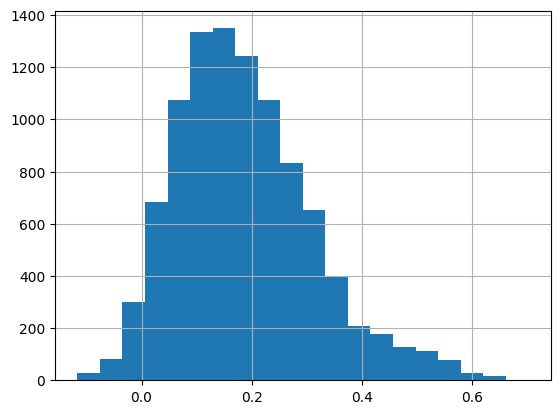

In [70]:
df['abstract_movement_similarity'].hist(bins=20)

Next, look at a sample of articles with different similarity scores, sorted by highest to lowest. The measure has some face validity, as the movementness of the articles declines across the clusters. 

In [71]:
# Step 1: Create quintiles
df['Quintile'] = pd.qcut(df['abstract_movement_similarity'], 20, labels=False)

# Step 2: Filter for the top quarter quintiles (quintiles 15-19)
top_half_quintiles = df[df['Quintile'] >= 15]

# Step 3: Display "Title" and "Source title" for a random sample of 5 rows within each top half quintile
for quintile in range(19, 14, -1):
    sample = top_half_quintiles[top_half_quintiles['Quintile'] == quintile].sample(n=5)
    print(f"Quintile {quintile + 1}:")
    display(sample[['Source title', 'Title', 'abstract_movement_similarity']])

Quintile 20:


,Source title,Title,abstract_movement_similarity
4666,Sociological Forum,"Going Green: Environmental Protest, Policy, and CO2 Emissions in U.S. States, 1990–2007",0.439596
3386,Social Currents,Tactics and targets: Explaining shifts in grassroots environmental resistance,0.476411
4199,Mobilization,Movement-countermovement dynamics and mobilizing the electorate,0.524236
1474,Sociological Forum,Be Careful What You Wish For: The Ironic Connection Between the Civil Rights Struggle and Today's Divided America,0.596116
8583,Sociological Inquiry,The Cultural and the Racial: Stitching Together the Sociology of Race and Ethnicity and the Sociology of Culture,0.429177


Quintile 19:


,Source title,Title,abstract_movement_similarity
7252,Qualitative Sociology,The Social Life of the State: Relational Ethnography and Political Sociology,0.366393
5255,Du Bois Review,"Rethinking models of minority political participation: Inter-and intra-group variation in political ""styles""",0.394801
5346,Social Forces,The Persuasive Power of Protest. How Protest wins Public Support,0.363187
1640,Social Psychology Quarterly,Samuel Stouffer and Relative Deprivation,0.362094
8030,Sociological Forum,"Broker Wisdom: How Migrants Navigate a Broker-Centric Migration System in Vietnam1,2",0.403658


Quintile 18:


,Source title,Title,abstract_movement_similarity
3620,Mobilization,Loud and clear: The effect of protest signals on congressional attention,0.335533
4417,Gender and Society,"“Manning Up” to be a Good Father: Hybrid Fatherhood, Masculinity, and U.S. Responsible Fatherhood Policy",0.315162
9603,City and Community,"Community Social Capital, Racial Diversity, and Philanthropic Resource Mobilization in the Time of a Pandemic",0.330078
2222,Sociological Perspectives,"Cultural Capital, Motherhood Capital, and Low-income Immigrant Mothers' Institutional Negotiations",0.339970
6999,Social Forces,"Emigration and Electoral Outcomes in Mexico: Democratic Diffusion, Clientelism, and Disengagement",0.326051


Quintile 17:


,Source title,Title,abstract_movement_similarity
881,Sociological Forum,"Changing Childrearing Beliefs Among Indigenous Rural-to-Urban Migrants in El Alto, Bolivia",0.291009
3873,American Journal of Sociology,"Interlock globally, act domestically: Corporate political unity in the 21st century",0.289036
2762,Social Problems,"Moral panic, moral breach: Bernhard goetz, george zimmerman, and racialized news reporting in contested cases of self-defense",0.302752
501,Du Bois Review,"Race, justice, and desegregation",0.290871
105,Symbolic Interaction,"Chicago, jazz and marijuana: Howard Becker on Outsiders",0.308609


Quintile 16:


,Source title,Title,abstract_movement_similarity
1024,Social Problems,Chilling Effects: Diminished Political Participation among Partners of Formerly Incarcerated Men,0.267233
7057,Gender and Society,"The Gender Mobility Paradox: Gender Segregation and Women’s Mobility Across Gender-Type Boundaries, 1970–2018",0.263790
7265,Social Forces,The Limits of Gaining Rights while Remaining Marginalized: The Deferred Action for Childhood Arrivals (DACA) Program and the Psychological Wellbeing of Latina/o Undocumented Youth,0.267221
873,Social Currents,"Rethinking organizational decoupling: Fields, power struggles, and work routines",0.267197
6205,Symbolic Interaction,Digitalization as “an Agent of Social Change” in a Supermarket Chain: Applying Blumer's Theory of Industrialization in Contemporary Society,0.271341


Another check. Which journals publish the most movement research?

<Axes: ylabel='Source title'>

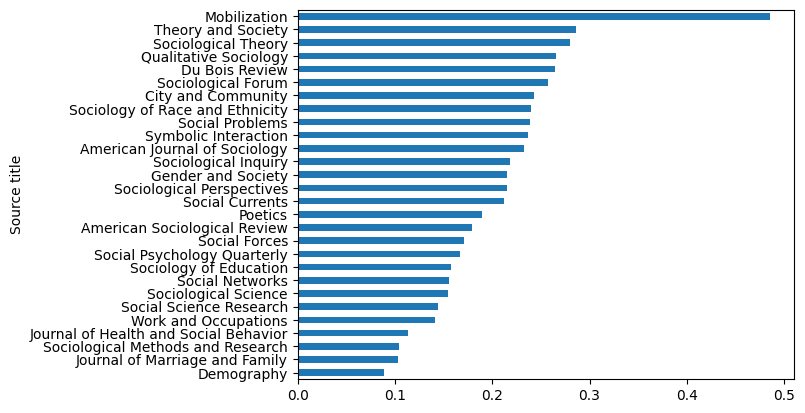

In [72]:
df.groupby('Source title')['abstract_movement_similarity'].mean().sort_values(ascending=True).plot(kind='barh')

And what's the most movementy article in each journal?

In [73]:
# Group by 'Source Title' and find the index of the max 'abstract_movement_similarity' in each group
idx = df.groupby('Source title')['abstract_movement_similarity'].idxmax()

# Filter the DataFrame to keep only the rows with the highest 'abstract_movement_similarity' in each group
highest_values_df = df.loc[idx]
display = ['Source title', 'Title', 'abstract_movement_similarity']
highest_values_df[display].sort_values(by='abstract_movement_similarity', ascending=False)

,Source title,Title,abstract_movement_similarity
1923,Mobilization,Social movements in an age of participation,0.702846
433,American Journal of Sociology,"Issue bricolage: Explaining the configuration of the social movement sector, 1960–1995",0.680012
3768,Social Problems,Economic breakdown and collective action,0.660584
4400,Sociology of Race and Ethnicity,The Anti-oppressive Value of Critical Race Theory and Intersectionality in Social Movement Study,0.652746
5221,Social Currents,Assessing the Explanatory Power of Social Movement Theories across the Life Course of the Civil Rights Movement,0.641801
8064,Sociological Perspectives,Policy Relay: How Affirmative Consent Went from Controversy to Convention,0.632110
4489,Theory and Society,Combining transition studies and social movement theory: towards a new research agenda,0.631707
6325,Social Forces,Pathways to modes of movement participation: Micromobilization in the nashville civil rights movement,0.629331
2482,American Sociological Review,Tactical Innovation in Social Movements: The Effects of Peripheral and Multi-Issue Protest,0.616886
6201,City and Community,"Confronting Scale: A Strategy of Solidarity in Urban Social Movements, New York City and Beyond",0.606433


Can I add to my CV that I have the [most movementy article](https://academic.oup.com/socpro/article-abstract/64/1/133/2670547?redirectedFrom=fulltext) in Social Problems? 

Okay, now a different concept. How quantitative is the research?

In [74]:

quantitative_words = ', '.join([
    "surveys",
    "experiments",
    "quasi-experiments",
    "regression analysis",
    "statistical analysis",
    "correlation",
])

quantitative_embedding = model.encode(quantitative_words)

In [75]:
df['abstract_quant_similarity'] = df['Abstract'].apply(string_embedding_sim, 
                                                       text2_embedding=quantitative_embedding)

<Axes: ylabel='Source title'>

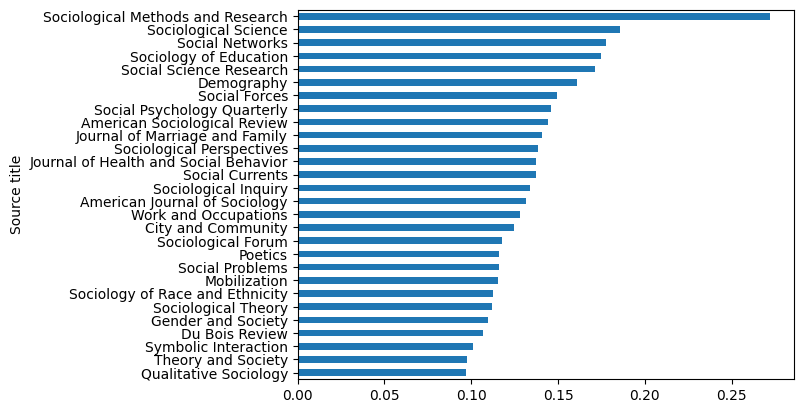

In [76]:
df.groupby('Source title')['abstract_quant_similarity'].mean().sort_values(ascending=True).plot(kind='barh')

Very plausible, although I *think* that *SM&R* scores highest both because the publish lots of quantitative work plus the abstracts rarely discuss anything but methods, so it's not quite an apples-to-apples comparison. 

Finally, how are the two concepts related at the abstract level?

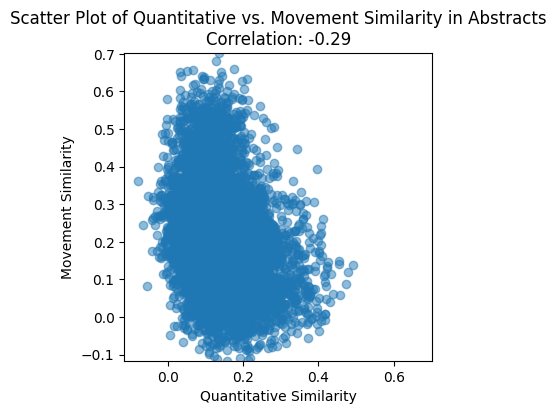

In [77]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assuming df is your DataFrame
# Calculate the Pearson correlation coefficient
correlation = df['abstract_quant_similarity'].corr(df['abstract_movement_similarity'])

# Determine the common range for both axes based on the min and max of both series
common_range = [
    min(df['abstract_quant_similarity'].min(), df['abstract_movement_similarity'].min()), 
    max(df['abstract_quant_similarity'].max(), df['abstract_movement_similarity'].max())
]

# Create the scatter plot with square dimensions
plt.figure(figsize=(4, 4))  # Makes the figure square in size
plt.scatter(df['abstract_quant_similarity'], df['abstract_movement_similarity'], alpha=0.5)

# Set the same range for both X and Y axes
plt.xlim(common_range)
plt.ylim(common_range)


# Add a title with the correlation coefficient, formatted to two decimal places
plt.title(f'Scatter Plot of Quantitative vs. Movement Similarity in Abstracts\nCorrelation: {correlation:.2f}')

# Add x and y labels
plt.xlabel('Quantitative Similarity')
plt.ylabel('Movement Similarity')

# Ensure the aspect ratio is equal to make the plot truly square
plt.gca().set_aspect('equal', adjustable='box')

plt.show()


I interpret this as both (1) movements research is not heavily quantitative and (2) abstracts that discuss movement theories and cases spend less time talking about methods, but that's is probably also true of most articles that are about something rather than methods. 

To do: Can you do math with sentence embeddings, like what's a similar paper but instead of analyzing surveys, uses in-depth interviews? Here's a sample code from ChatGPT.